# Project Part 3: Final Model

## Getting Images from files

This is the same as in ./data-exploration.ipynb

In [1]:
import os

# define the directories where the imgaes are

pizza_directory="./pizza/"
not_pizza_directory="./not_pizza/"

# get the images from the directories

not_pizza_files=[[0, not_pizza_directory, i] for i in os.listdir(not_pizza_directory)]
pizza_files=[[1, pizza_directory, i] for i in os.listdir(pizza_directory)]

print("Number of pizza images:",len(pizza_files))
print("Number of non-pizza images:",len(not_pizza_files))

# combine the image sets

all_files = not_pizza_files + pizza_files

print("Total number of images:", len(all_files))

# each element in all_files is of the format [is_pizza: boolean, directory: string, filename: string]
# in other words, for each `img` in `all_files`:
#    - img[0] = 0 if not pizza, 1 if pizza
#    - img[1] = directory where the image is
#    - img[2] = file name

Number of pizza images: 983
Number of non-pizza images: 983
Total number of images: 1966


## Preprocessing the data

Resize all images to 512x512 and put them into a new directory.

Create the following arrays:

- **X** - array of the pixel rgb values of the resized images. Each element is in the shape **[512][512][3]**
- **y** - array of whether the corresponding image is of a pizza or not. Each element is a **Boolean**

In [2]:
from PIL import Image

import numpy as np

standardSize = (128,128)

resizedImages = list()
isPizzaArray = list()

# structure is:
# resizedImages[i] = 2-D numpy array of pixels, [128][128][3]


PATH = os.path.abspath(os.getcwd())

dirExists = os.path.exists(f'{PATH}/resizedImages')

if (not dirExists):
    os.mkdir('resizedImages')

for i, image in enumerate(all_files):
    imgData = Image.open(image[1] + image[2])
    imgData = imgData.resize(standardSize)
    imgData.save(f'{PATH}/resizedImages/{i}.jpg')
    # storing images
    resizedImages.append(np.array(imgData, np.uint8))
    isPizzaArray.append(image[0])

# ! Takes about 30 seconds...

### Convert resizedImages and y to numpy arrary for ANN

In [3]:
X = np.array(resizedImages, np.uint8)
y = np.array(isPizzaArray, np.uint8)
print(len(X))
   
print(len(y))

print(X.shape)
print(y.shape)

1966
1966
(1966, 128, 128, 3)
(1966,)


## Final Model

(Add description)

### Splitting into testing and training dataset

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

print(X_train.shape)
print(X_test.shape)

(1376, 128, 128, 3)
(590, 128, 128, 3)


In [5]:
from sklearn.svm import SVC

totalSize = standardSize[0]*standardSize[1]*3

X_train1=np.array(X_train.reshape((X_train.shape[0], totalSize)), dtype=np.uint8)

SVM_cl=SVC(kernel='rbf')
SVM_cl.fit(X_train1,y_train)

print('SVM training complete')

#X_all = np.array(X.reshape((X.shape[0], totalSize)), dtype=np.uint8)
yhatsvm = SVM_cl.predict(X_train1)
#print(len(yhatsvm))

# ! Take about 5 minutes...

SVM training complete


### Create the model and fit training data

In [16]:
from keras.layers import Conv2D, Flatten, Dense, Input, Concatenate
from keras.models import Sequential, Model
model = Sequential() # Initialising the ANN
# build your convulusional layers here:

imgShape = (standardSize[0], standardSize[1], 3)

input = Input(shape = imgShape)

model = Conv2D(15, 3, input_shape=imgShape, activation = 'tanh')(input)
model = Conv2D(10, 3, activation = 'relu')(model)
model = Conv2D(5, 3, activation = 'relu')(model)
# model = Conv2D(20, 3, activation = 'relu')(model)


# make sure you flatten after you convulusional layers here:

model = Flatten()(model)

# refered to https://stackoverflow.com/questions/48473957/adding-new-features-to-the-output-of-flatten-layer-in-keras

otherInp = Input(shape = (1, ))

model = Concatenate(axis = 1)([model, otherInp])

# Feel free to add hidden layers here: 

# model = Dense(units = 7, activation = 'relu')(model)

# # Hint reduce to a 1d vector as you have in the previous exercises.
output = Dense(units = 1, activation = 'sigmoid')(model)

# compile your model here:

model = Model(inputs = [input, otherInp], outputs = output)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

# print(model.summary())

numEpoches = 5

In [17]:
import numpy as np

modelData = model.fit([X_train, yhatsvm], y_train, batch_size = 3, epochs = numEpoches, verbose = 1)

# ! Takes about 1-2 minutes

Epoch 1/5
459/459 [==============================] - 27s 55ms/step - loss: 0.8755
Epoch 2/5
459/459 [==============================] - 18s 39ms/step - loss: 0.7013
Epoch 3/5
459/459 [==============================] - 24s 53ms/step - loss: 0.5660
Epoch 4/5
459/459 [==============================] - 22s 49ms/step - loss: 0.4294
Epoch 5/5
459/459 [==============================] - 19s 41ms/step - loss: 0.3020


## Classification Report for Testing and Training Data

In [18]:
X_test1 = np.array(X_test.reshape((X_test.shape[0], totalSize)), dtype=np.uint8)

yhatsadf = SVM_cl.predict(X_test1)

In [28]:
from sklearn.metrics import classification_report

input = [X_train, yhatsvm]

yhat = model.predict(input)
yhat = [0 if y<=0.5 else 1 for y in yhat]

print('Training Data Classification Report')
print(classification_report(y_train, yhat))

yhat_test = model.predict([X_test, yhatsadf])
yhat_test = [0 if y<=0.5 else 1 for y in yhat_test]

print('Test Data Classification Report')
print(classification_report(y_test, yhat_test))

# ! Takes about 10 seconds...

43/43 [==============================] - 5s 107ms/step
Training Data Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       685
           1       0.92      0.96      0.94       691

    accuracy                           0.94      1376
   macro avg       0.94      0.94      0.94      1376
weighted avg       0.94      0.94      0.94      1376

19/19 [==============================] - 2s 129ms/step
Test Data Classification Report
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       298
           1       0.62      0.70      0.66       292

    accuracy                           0.64       590
   macro avg       0.64      0.64      0.64       590
weighted avg       0.64      0.64      0.64       590



## Where does our model lie on the fitting curve?

We notice that our model overfits our training data, while our model performs slightly better than a coin toss for the testing data.

So our model lies in the fitting curve as shown below

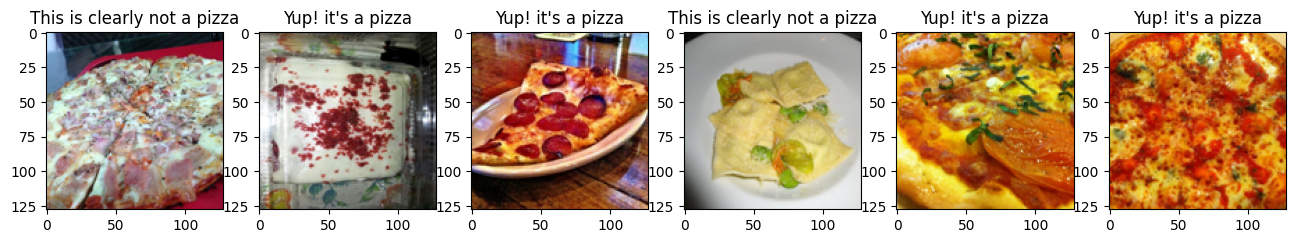

In [31]:
import matplotlib.pyplot as plt
import numpy as np

imgs = X_test

n = 6
fig, ax = plt.subplots(1, n, figsize=(16,8))
for ix in range(n):
    num = np.random.randint(imgs.shape[0])
    ax[ix].imshow(imgs[num])
    if yhat_test[num] == 0:
        ax[ix].set_title('This is clearly not a pizza')
    else:
        ax[ix].set_title('Yup! it\'s a pizza')